In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ttest_ind
from sklearn.ensemble import VotingRegressor
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from scipy.stats import norm
from scipy.stats import ttest_ind
import joblib
import math

## Loading the Data

In [35]:
splitting_seed=42
np.random.seed(splitting_seed)
top_age=75# chaning this metric changes the upper bound of the target region
Num_models=50

#######
#Replace with proper addresses of sampled data. Data used here was seperated by E4-carriers and E4-NCS
#######
E4_AD_data_fp="C:/Users/woods/OneDrive/Documents/Research/Brain Lab/brain age paper/Sampled Data/both_apoe4_ad.csv"
NC_AD_data_fp="C:/Users/woods/OneDrive/Documents/Research/Brain Lab/brain age paper/Sampled Data/both_nonapoe4_ad.csv"
CU_data_fp="C:/Users/woods/OneDrive/Documents/Research/Brain Lab/brain age paper/Sampled Data/sampled_cn2.csv"

apoe4_ad=pd.read_csv(E4_AD_data_fp).fillna(0)
apoe4_ad['label']=pd.DataFrame(np.ones((apoe4_ad.shape[0])))
apoe4_ad['APOE4']=1 #adds genotype information

nonapoe4_ad=pd.read_csv(NC_AD_data_fp).fillna(0)
nonapoe4_ad['label']=pd.DataFrame(np.zeros((nonapoe4_ad.shape[0])))
nonapoe4_ad['APOE4']=0 #adds genotype information

data_cn=pd.read_csv(CU_data_fp)#already gentically labeled
#sort by genetic labels
apoe4_cn=data_cn[data_cn['APOE4']==1]
nonapoe4_cn=data_cn[data_cn['APOE4']==0] 


features = [ "CBTIA_1.0", "DEP2YRS_1.0", "DIABETES_1.0", "SOMATIC_1.0", "NACCBMI","INCONTU_1.0","EDUC",
          "B12DEF_2.0", "BPDIAS", "BPSYS", "HRATE", "SMOKYRS", "VISWCORR_1.0", "B12DEF_1.0", "NACCBETA_1.0", 
         "NACCLIPL_1.0", "NACCDBMD_1.0", "SEX",'APOE4']

brain = ["NACCAGE", "CEREALL", "CERECSF", "CEREGR", "CERETISS", "CEREWH", "CSFVOL", "FRCORT", "GRAYVOL", "HIPPOVOL", "LATVENT",
        "LCAC", "LCACM", "LCMF", "LCMFM", "LCUN", "LCUNM", "LENT", "LENTM", "LFRCORT", "LFUS", "LFUSM", "LHIPPO", "LINFPAR",
        "LINFPARM", "LINFTEMM", "LINFTEMP", "LINSULA","LINSULAM","LISTHC","LISTHCM","LLATOCC","LLATOCCM","LLATORBF",
        "LLATORBM","LLATVENT","LLING","LLINGM","LMEDORBF","LMEDORBM","LMIDTEMM","LMIDTEMP", "LOCCORT","LPARCEN","LPARCENM",
        "LPARCORT", "LPARHIP", "LPARHIPM", "LPARORB", "LPARORBM", "LPARSOP", "LPARSOPM", "LPARTRI", "LPARTRIM", "LPERCAL",
        "LPERCALM", "LPOSCEN", "LPOSCENM", "LPOSCIN", "LPOSCINM", "LPRECEN", "LPRECENM", "LPRECUN", "LPRECUNM", "LROSANC",
        "LROSANCM", "LROSMF", "LROSMFM", "LSUPFR", "LSUPFRM", "LSUPMAR", "LSUPMARM", "LSUPPAR", "LSUPPARM", "LSUPTEM", "LSUPTEMM",
        "LTEMPCOR", "LTRTEM", "LTRTEMM", "NACCBRNV", "NACCICV", "NACCWMVL", "OCCCORT", "PARCORT", "RCAC", "RCACM",
        "RCMF", "RCMFM", "RCUN", "RCUNM", "RENT", "RENTM", "RFRCORT", "RFUS", "RFUSM", "RHIPPO", "RINFPAR", "RINFPARM",
        "RINFTEMM", "RINFTEMP", "RINSULA", "RINSULAM", "RISTHC", "RISTHCM", "RLATOCC", "RLATOCCM", "RLATORBF", "RLATORBM",
        "RLATVENT", "RLING", "RLINGM", "RMEDORBF", "RMEDORBM", "RMIDTEMM", "RMIDTEMP", "ROCCORT", "RPARCEN", "RPARCENM",
        "RPARCORT", "RPARHIP", "RPARHIPM", "RPARORB", "RPARORBM", "RPARSOP", "RPARSOPM", "RPARTRI", "RPARTRIM", "RPERCAL",
        "RPERCALM", "RPOSCEN", "RPOSCENM", "RPOSCIN", "RPOSCINM", "RPRECEN", "RPRECENM", "RPRECUN", "RPRECUNM", "RROSANC",
        "RROSANCM", "RROSMF", "RROSMFM", "RSUPFR", "RSUPFRM", "RSUPMAR", "RSUPMARM", "RSUPPAR", "RSUPPARM", "RSUPTEM", 
        "RSUPTEMM", "RTEMPCOR", "RTRTEM", "RTRTEMM", "TEMPCOR", "THIRVENT", "WHITEVOL", "WMHVOL"]

all_features=brain+features

data_cn=data_cn[all_features]

########################Set data to features for APOE4 groups###########
apoe4_cn=apoe4_cn[all_features]
nonapoe4_cn=nonapoe4_cn[all_features]
apoe4_ad=apoe4_ad[all_features]
nonapoe4_ad=nonapoe4_ad[all_features]



########################Set data to features for Gender groups###########
data_cn=data_cn[all_features]
data_cn_MALE=data_cn[data_cn['SEX']==1]
data_cn_FEMALE=data_cn[data_cn['SEX']==2]
########################################################################

###########Seperate target variables #############
x_all_cu=data_cn.drop(["NACCAGE"], axis=1)
y_all_cu=data_cn.NACCAGE

x_apoe4_cu=apoe4_cn.drop(["NACCAGE"], axis=1)
y_apoe4_cu=apoe4_cn.NACCAGE
x_non_cu=nonapoe4_cn.drop(["NACCAGE"], axis=1)
y_non_cu=nonapoe4_cn.NACCAGE

data_apoe4_ad=apoe4_ad[apoe4_ad.NACCAGE<top_age]
data_non_ad=nonapoe4_ad[nonapoe4_ad.NACCAGE<top_age]
########################################################################################
ad_data_all=pd.concat([data_apoe4_ad,data_non_ad])#####################################
#########################################################################################

####################################################


#######For generating gender seperated data#############

data_ad_MALE=ad_data_all[ad_data_all['SEX']==1]
data_ad_FEMALE=ad_data_all[ad_data_all['SEX']==2]

data_ad1=data_ad_MALE[data_ad_MALE.NACCAGE<top_age]#
data_ad2=data_ad_FEMALE[data_ad_FEMALE.NACCAGE<top_age]#

x_male_cu=data_cn_MALE.drop(["NACCAGE"], axis=1)
y_male_cu=data_cn_MALE.NACCAGE

x_female_cu=data_cn_FEMALE.drop(["NACCAGE"], axis=1)
y_female_cu=data_cn_FEMALE.NACCAGE

x_male_ad=data_ad1.drop(["NACCAGE"], axis=1)
y_male_ad=data_ad1.NACCAGE

x_female_ad=data_ad2.drop(["NACCAGE"], axis=1)
y_female_ad=data_ad2.NACCAGE

x_all_ad=ad_data_all.drop(["NACCAGE"],axis=1)
y_all_ad=ad_data_all.NACCAGE 
#########################################################


import math

############## For groups D and E (Gender Comp)#######################
target_length_D=math.ceil(len(x_female_cu)/2)
target_length_E=math.ceil(len(x_male_cu)/2)


indices_to_keep_D_fm=np.random.choice(len(x_female_cu),target_length_D,replace=False)
indices_to_keep_D_ml=np.random.choice(len(x_male_cu),target_length_D,replace=False)
x_group_D_cu=pd.concat([x_female_cu.iloc[indices_to_keep_D_fm],x_male_cu.iloc[indices_to_keep_D_ml]],axis=0)
y_group_D_cu=pd.concat([y_female_cu.iloc[indices_to_keep_D_fm],y_male_cu.iloc[indices_to_keep_D_ml]],axis=0)

indices_to_keep_E=np.random.choice(len(x_female_cu),target_length_E,replace=False)
indices_to_keep_E=np.random.choice(len(x_male_cu),target_length_E,replace=False)
x_group_E_cu=pd.concat([x_female_cu.iloc[indices_to_keep_E],x_male_cu.iloc[indices_to_keep_E]],axis=0)
y_group_E_cu=pd.concat([y_female_cu.iloc[indices_to_keep_E],y_male_cu.iloc[indices_to_keep_E]],axis=0)
###########################################################################







np.random.seed(0)#9999

Gender Specific training

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Define cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)
Num_models=25

split_indices_A = list(cv.split(x_female_cu))
split_indices_B = list(cv.split(x_male_cu))
split_indices_C=list(cv.split(x_all_cu))
split_indices_D=list(cv.split(x_group_D_cu))
split_indices_E=list(cv.split(x_group_E_cu))

all_split_indices=[split_indices_A,split_indices_B,split_indices_C,split_indices_D,split_indices_E]
ave_result_cu_A = []
ave_result_ad_A = []

ave_result_cu_B = []
ave_result_ad_B = []

ave_result_cu_C_fm = []
ave_result_ad_C_fm = []
ave_result_cu_C_ml = []
ave_result_ad_C_ml = []

ave_result_cu_D_fm = []
ave_result_cu_D_ml = []
ave_result_ad_D_fm = []
ave_result_ad_D_ml = []

ave_result_cu_E_fm = []
ave_result_cu_E_ml = []
ave_result_ad_E_fm = []
ave_result_ad_E_ml = []

# Array of smooth predictions
ave_result_array = [
    ave_result_cu_A,
    ave_result_cu_B,
    ave_result_cu_C_fm,
    ave_result_cu_C_ml,
    ave_result_cu_D_fm,
    ave_result_cu_D_ml,
    ave_result_cu_E_fm,
    ave_result_cu_E_ml,
    ave_result_ad_A,
    ave_result_ad_B,
    ave_result_ad_C_fm,
    ave_result_ad_C_ml,
    ave_result_ad_D_fm,
    ave_result_ad_D_ml,
    ave_result_ad_E_fm,
    ave_result_ad_E_ml
]
####################################
# Define smooth RL values for each category with sub-categories for 'fm' and 'ml'
smooth_rl_vals_cu_A = []
smooth_rl_vals_ad_A = []

smooth_rl_vals_cu_B = []
smooth_rl_vals_ad_B = []

smooth_rl_vals_cu_C_fm = []
smooth_rl_vals_ad_C_fm = []
smooth_rl_vals_cu_C_ml = []
smooth_rl_vals_ad_C_ml = []

smooth_rl_vals_cu_D_fm = []
smooth_rl_vals_cu_D_ml = []
smooth_rl_vals_ad_D_fm = []
smooth_rl_vals_ad_D_ml = []

smooth_rl_vals_cu_E_fm = []
smooth_rl_vals_cu_E_ml = []
smooth_rl_vals_ad_E_fm = []
smooth_rl_vals_ad_E_ml = []

# Array of smooth RL values
smooth_rl_vals_array = [
    smooth_rl_vals_cu_A,
    smooth_rl_vals_cu_B,
    smooth_rl_vals_cu_C_fm,
    smooth_rl_vals_cu_C_ml,
    smooth_rl_vals_cu_D_fm,
    smooth_rl_vals_cu_D_ml,
    smooth_rl_vals_cu_E_fm,
    smooth_rl_vals_cu_E_ml,
    smooth_rl_vals_ad_A,
    smooth_rl_vals_ad_B,
    smooth_rl_vals_ad_C_fm,
    smooth_rl_vals_ad_C_ml,
    smooth_rl_vals_ad_D_fm,
    smooth_rl_vals_ad_D_ml,
    smooth_rl_vals_ad_E_fm,
    smooth_rl_vals_ad_E_ml
]

##################################
##################################
# Define smooth predictions for each category with sub-categories for 'fm' and 'ml'
smooth_preds_cu_A = []
smooth_preds_ad_A = []

smooth_preds_cu_B = []
smooth_preds_ad_B = []

smooth_preds_cu_C_fm = []
smooth_preds_ad_C_fm = []
smooth_preds_cu_C_ml = []
smooth_preds_ad_C_ml = []

smooth_preds_cu_D_fm = []
smooth_preds_cu_D_ml = []
smooth_preds_ad_D_fm = []
smooth_preds_ad_D_ml = []

smooth_preds_cu_E_fm = []
smooth_preds_cu_E_ml = []
smooth_preds_ad_E_fm = []
smooth_preds_ad_E_ml = []

# Array of smooth predictions
smooth_preds_array = np.empty(16, dtype=object)

###############################
###############################
# Define smooth predictions lists for each category
smooth_preds_cu_list_A = []
smooth_preds_cu_list_B = []
smooth_preds_cu_list_C_fm = []
smooth_preds_cu_list_C_ml = []
smooth_preds_cu_list_D_fm = []
smooth_preds_cu_list_D_ml = []
smooth_preds_cu_list_E_fm = []
smooth_preds_cu_list_E_ml = []

smooth_preds_ad_list_A = []
smooth_preds_ad_list_B = []
smooth_preds_ad_list_C_fm = []
smooth_preds_ad_list_C_ml = []
smooth_preds_ad_list_D_fm = []
smooth_preds_ad_list_D_ml = []
smooth_preds_ad_list_E_fm = []
smooth_preds_ad_list_E_ml = []

# Array of smooth predictions lists

ensemble_predictions_cu_A = []
ensemble_predictions_ad_A = []

ensemble_predictions_cu_B = []
ensemble_predictions_ad_B = []

ensemble_predictions_cu_C_fm = []
ensemble_predictions_ad_C_fm = []
ensemble_predictions_cu_C_ml = []
ensemble_predictions_ad_C_ml = []

ensemble_predictions_cu_D_fm = []
ensemble_predictions_cu_D_ml = []
ensemble_predictions_ad_D_fm = []
ensemble_predictions_ad_D_ml = []

ensemble_predictions_cu_E_fm = []
ensemble_predictions_cu_E_ml = []
ensemble_predictions_ad_E_fm = []
ensemble_predictions_ad_E_ml = []


# Array of smooth predictions lists
smooth_preds_lists_array = np.empty((Num_models,16),dtype=object)
################################
for i in range(Num_models):
    ################################
# Define ensemble predictions for each category with sub-categories for 'fm' and 'ml'
# New term
    ###################################

    ##################################
    ensemble_predictions_cu_A = []
    ensemble_predictions_ad_A = []

    ensemble_predictions_cu_B = []
    ensemble_predictions_ad_B = []

    ensemble_predictions_cu_C_fm = []
    ensemble_predictions_ad_C_fm = []
    ensemble_predictions_cu_C_ml = []
    ensemble_predictions_ad_C_ml = []

    ensemble_predictions_cu_D_fm = []
    ensemble_predictions_cu_D_ml = []
    ensemble_predictions_ad_D_fm = []
    ensemble_predictions_ad_D_ml = []

    ensemble_predictions_cu_E_fm = []
    ensemble_predictions_cu_E_ml = []
    ensemble_predictions_ad_E_fm = []
    ensemble_predictions_ad_E_ml = []
    # Define real values lists for each category

    real_vals_cu_A = []
    real_vals_cu_B = []
    real_vals_ad_A = []
    real_vals_ad_B = []

    real_vals_cu_C_fm = []
    real_vals_cu_C_ml = []
    real_vals_ad_C_fm = []
    real_vals_ad_C_ml = []

    real_vals_cu_D_fm = []
    real_vals_cu_D_ml = []
    real_vals_ad_D_fm = []
    real_vals_ad_D_ml = []

    real_vals_cu_E_fm = []
    real_vals_cu_E_ml = []
    real_vals_ad_E_fm = []
    real_vals_ad_E_ml = []

    # Array of real values lists

#################################### Training sector #######################################################################
    model=RandomForestRegressor(n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=30)

    for split_group_num, split_indices in enumerate(all_split_indices):
        for fold_num, (train_index, test_index) in enumerate(split_indices):
            print(split_group_num)
            if split_group_num==0:#A
                x_cn=x_female_cu
                y_cn=y_female_cu
                x_ad=x_female_ad
            if split_group_num==1:#B
                x_cn=x_male_cu
                y_cn=y_male_cu
                x_ad=x_male_ad
            if split_group_num==2:#C
                x_cn=x_all_cu
                y_cn=y_all_cu

                x_ad=x_all_ad
            if split_group_num==3:#D
                x_cn=x_group_D_cu
                y_cn=y_group_D_cu
                x_ad=x_all_ad
            if split_group_num==4:#E
                x_cn=x_group_E_cu
                y_cn=y_group_E_cu
                x_ad=x_all_ad
            x_cn = pd.DataFrame(x_cn)
            y_cn = pd.DataFrame(y_cn)
            x_ad = pd.DataFrame(x_ad)
            y_all_ad=pd.DataFrame(y_all_ad)
            print("split group num=",split_group_num)

            x_train, x_test = x_cn.iloc[train_index], x_cn.iloc[test_index]
            y_train, y_test = y_cn.iloc[train_index], y_cn.iloc[test_index]


  



            #y_test_ad=risk_factor_specific_training.ipynb
            print('model fitting')
            model.fit(x_train, y_train)
            print('fitting complete')
###############################################################################################################
            x_cn = pd.DataFrame(x_cn)
            y_cn = pd.DataFrame(y_cn)
            x_ad = pd.DataFrame(x_ad)
############################################ Testing for each groups      #####################################
            if (split_group_num==0):# Group A
                y_pred_cu_A=model.predict(x_test)
                y_pred_ad_A=model.predict(x_female_ad)
                ensemble_predictions_cu_A.append(y_pred_cu_A)
                ensemble_predictions_ad_A.append(y_pred_ad_A)
                real_vals_cu_A.append(y_test)
                real_vals_ad_A.append(y_all_ad[x_all_ad['SEX']==2])

            if (split_group_num==1):#Group B
                y_pred_cu_B=model.predict(x_test)
                y_pred_ad_B=model.predict(x_male_ad)
                ensemble_predictions_cu_B.append(y_pred_cu_B)
                ensemble_predictions_ad_B.append(y_pred_ad_B)
                real_vals_cu_B.append(y_test)
                real_vals_ad_B.append(y_all_ad[x_all_ad['SEX']==1])

            if (split_group_num==2):#Group C
                y_pred_cu_fm_C=model.predict(x_test[x_test['SEX']==2])
                y_pred_ad_fm_C=model.predict(x_all_ad[x_all_ad['SEX']==2])
                ensemble_predictions_cu_C_fm.append(y_pred_cu_fm_C)
                ensemble_predictions_ad_C_fm.append(y_pred_ad_fm_C)
                real_vals_cu_C_fm.append(y_test[x_test['SEX']==2])
                real_vals_ad_C_fm.append(y_all_ad[x_all_ad['SEX']==2])

                y_pred_cu_ml_C=model.predict(x_test[x_test['SEX']==1])
                y_pred_ad_ml_C=model.predict(x_all_ad[x_all_ad['SEX']==1])
                ensemble_predictions_cu_C_ml.append(y_pred_cu_ml_C)
                ensemble_predictions_ad_C_ml.append(y_pred_ad_ml_C)
                real_vals_cu_C_ml.append(y_test[x_test['SEX']==1])
                real_vals_ad_C_ml.append(y_all_ad[x_all_ad['SEX']==1])

            if (split_group_num==3):#Group D
                y_pred_cu_D_fm=model.predict(x_test[x_test['SEX']==2])
                y_pred_ad_D_fm=model.predict(x_all_ad[x_all_ad['SEX']==2])
                ensemble_predictions_cu_D_fm.append(y_pred_cu_D_fm)
                ensemble_predictions_ad_D_fm.append(y_pred_ad_D_fm)
                real_vals_cu_D_fm.append(y_test[x_test['SEX']==2])
                real_vals_ad_D_fm.append(y_all_ad[x_all_ad['SEX']==2])

                y_pred_cu_D_ml=model.predict(x_test[x_test['SEX']==1])
                y_pred_ad_D_ml=model.predict(x_all_ad[x_all_ad['SEX']==1])
                ensemble_predictions_cu_D_ml.append(y_pred_cu_D_ml)
                ensemble_predictions_ad_D_ml.append(y_pred_ad_D_ml)
                real_vals_cu_D_ml.append(y_test[x_test['SEX']==1])
                real_vals_ad_D_ml.append(y_all_ad[x_all_ad['SEX']==1])

            if (split_group_num==4):#Group #
                y_pred_cu_E_fm=model.predict(x_test[x_test['SEX']==2])
                y_pred_ad_E_fm=model.predict(x_all_ad[x_all_ad['SEX']==2])
                ensemble_predictions_cu_E_fm.append(y_pred_cu_E_fm)
                ensemble_predictions_ad_E_fm.append(y_pred_ad_E_fm)
                real_vals_cu_E_fm.append(y_test[x_test['SEX']==2])
                real_vals_ad_E_fm.append(y_all_ad[x_all_ad['SEX']==2])

                y_pred_cu_E_ml=model.predict(x_test[x_test['SEX']==1])
                y_pred_ad_E_ml=model.predict(x_all_ad[x_all_ad['SEX']==1])
                ensemble_predictions_cu_E_ml.append(y_pred_cu_E_ml)
                ensemble_predictions_ad_E_ml.append(y_pred_ad_E_ml)
                real_vals_cu_E_ml.append(y_test[x_test['SEX']==1])
                real_vals_ad_E_ml.append(y_all_ad[x_all_ad['SEX']==1])
##############################################################################################################
    ensembled_preds_array = [
    ensemble_predictions_cu_A,
    ensemble_predictions_cu_B,
    ensemble_predictions_cu_C_fm,
    ensemble_predictions_cu_C_ml,
    ensemble_predictions_cu_D_fm,   # New term
    ensemble_predictions_cu_D_ml,   # New term
    ensemble_predictions_cu_E_fm,   # New term
    ensemble_predictions_cu_E_ml,   # New term
    ensemble_predictions_ad_A,
    ensemble_predictions_ad_B,
    ensemble_predictions_ad_C_fm,
    ensemble_predictions_ad_C_ml,
    ensemble_predictions_ad_D_fm,   # New term
    ensemble_predictions_ad_D_ml,   # New term
    ensemble_predictions_ad_E_fm,   # New term
    ensemble_predictions_ad_E_ml]  

    real_vals_array = [
    real_vals_cu_A,
    real_vals_cu_B,
    real_vals_cu_C_fm,
    real_vals_cu_C_ml,
    real_vals_cu_D_fm,
    real_vals_cu_D_ml,
    real_vals_cu_E_fm,
    real_vals_cu_E_ml,
    real_vals_ad_A,
    real_vals_ad_B,
    real_vals_ad_C_fm,
    real_vals_ad_C_ml,
    real_vals_ad_D_fm,
    real_vals_ad_D_ml,
    real_vals_ad_E_fm,
    real_vals_ad_E_ml
]


############################################ Ensembling Portion ##############################################

    for j in range(16):#range is jsut size of all arrays.

        smooth_rl_vals_array[j]=np.concatenate(real_vals_array[j])
        if j<8:
            smooth_preds_array[j]=np.concatenate(ensembled_preds_array[j])
        if j>=8:
            smooth_preds_array[j]=np.mean(ensembled_preds_array[j],axis=0)
        smooth_preds_lists_array[i][j]=(np.array(smooth_preds_array[j]))



ave_result_array=np.mean(smooth_preds_lists_array,axis=0)



Prepare data for further analysis

In [42]:
for i in range(len(smooth_rl_vals_array)):
    hold=smooth_rl_vals_array[i].flatten()
    smooth_rl_vals_array[i]=hold

smooth_rl_vals_cu_A = smooth_rl_vals_array[0]
smooth_rl_vals_cu_B = smooth_rl_vals_array[1]

smooth_rl_vals_cu_C_fm = smooth_rl_vals_array[2]
smooth_rl_vals_cu_C_ml = smooth_rl_vals_array[3]

smooth_rl_vals_cu_D_fm = smooth_rl_vals_array[4]
smooth_rl_vals_cu_D_ml = smooth_rl_vals_array[5]


smooth_rl_vals_cu_E_fm = smooth_rl_vals_array[6]
smooth_rl_vals_cu_E_ml = smooth_rl_vals_array[7]


smooth_rl_vals_ad_A = smooth_rl_vals_array[8][:int(len(smooth_rl_vals_array[8]) / 5)]
smooth_rl_vals_ad_B = smooth_rl_vals_array[9][:int(len(smooth_rl_vals_array[9]) / 5)]

smooth_rl_vals_ad_C_fm = smooth_rl_vals_array[10][:int(len(smooth_rl_vals_array[10]) / 5)]
smooth_rl_vals_ad_C_ml = smooth_rl_vals_array[11][:int(len(smooth_rl_vals_array[11]) / 5)]


smooth_rl_vals_ad_D_fm = smooth_rl_vals_array[12][:int(len(smooth_rl_vals_array[12]) / 5)]
smooth_rl_vals_ad_D_ml = smooth_rl_vals_array[13][:int(len(smooth_rl_vals_array[13]) / 5)]


smooth_rl_vals_ad_E_fm = smooth_rl_vals_array[14][:int(len(smooth_rl_vals_array[14]) / 5)]
smooth_rl_vals_ad_E_ml = smooth_rl_vals_array[15][:int(len(smooth_rl_vals_array[15]) / 5)]





###########################################################
###########################################################

ave_result_cu_A = ave_result_array[0] 
ave_result_cu_B = ave_result_array[1] 

ave_result_cu_C_fm = ave_result_array[2] 
ave_result_cu_C_ml = ave_result_array[3]

ave_result_cu_D_fm = ave_result_array[4]  
ave_result_cu_D_ml = ave_result_array[5] 

ave_result_cu_E_fm = ave_result_array[6]  
ave_result_cu_E_ml = ave_result_array[7]  

ave_result_ad_A = ave_result_array[8] 
ave_result_ad_B = ave_result_array[9] 

ave_result_ad_C_fm = ave_result_array[10] 
ave_result_ad_C_ml = ave_result_array[11]  

ave_result_ad_D_fm = ave_result_array[12] 
ave_result_ad_D_ml = ave_result_array[13]  

ave_result_ad_E_fm = ave_result_array[14]  
ave_result_ad_E_ml = ave_result_array[15]  


Saving Data

In [ ]:
import numpy as np

# Replace with your file path
file_path = 'C:/Users/woods/OneDrive/Documents/Brain Lab/brain age paper/New code/risk_factor_gender'

# Saving the NumPy arrays
np.savetxt(f'{file_path}/ave_results_cn1.csv', ave_result_cu_A, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/ave_results_ad1.csv', ave_result_ad_A, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/ave_results_cn2.csv', ave_result_cu_B, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/ave_results_ad2.csv', ave_result_ad_B, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/ave_results_cn3_fm.csv', ave_result_cu_C_fm, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/ave_results_ad3_fm.csv', ave_result_ad_C_fm, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/ave_results_cn3_ml.csv', ave_result_cu_C_ml, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/ave_results_ad3_ml.csv', ave_result_ad_C_ml, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/ave_results_cn4_fm.csv', ave_result_cu_D_fm, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/ave_results_ad4_fm.csv', ave_result_ad_D_fm, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/ave_results_cn4_ml.csv', ave_result_cu_D_ml, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/ave_results_ad4_ml.csv', ave_result_ad_D_ml, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/ave_results_cn5_fm.csv', ave_result_cu_E_fm, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/ave_results_ad5_fm.csv', ave_result_ad_E_fm, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/ave_results_cn5_ml.csv', ave_result_cu_E_ml, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/ave_results_ad5_ml.csv', ave_result_ad_E_ml, delimiter=',', fmt='%f')





np.savetxt(f'{file_path}/smooth_rl_vals_cn1.csv', smooth_rl_vals_cu_A, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/smooth_rl_vals_ad1.csv', smooth_rl_vals_ad_A, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/smooth_rl_vals_cn2.csv', smooth_rl_vals_cu_B, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/smooth_rl_vals_ad2.csv', smooth_rl_vals_ad_B, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/smooth_rl_vals_cn3_fm.csv', smooth_rl_vals_cu_C_fm, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/smooth_rl_vals_ad3_fm.csv', smooth_rl_vals_ad_C_fm, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/smooth_rl_vals_cn3_ml.csv', smooth_rl_vals_cu_C_ml, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/smooth_rl_vals_ad3_ml.csv', smooth_rl_vals_ad_C_ml, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/smooth_rl_vals_cn4_fm.csv', smooth_rl_vals_cu_D_fm, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/smooth_rl_vals_ad4_fm.csv', smooth_rl_vals_ad_D_fm, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/smooth_rl_vals_cn4_ml.csv', smooth_rl_vals_cu_D_ml, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/smooth_rl_vals_ad4_ml.csv', smooth_rl_vals_ad_D_ml, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/smooth_rl_vals_cn5_fm.csv', smooth_rl_vals_cu_E_fm, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/smooth_rl_vals_ad5_fm.csv', smooth_rl_vals_ad_E_fm, delimiter=',', fmt='%f')

np.savetxt(f'{file_path}/smooth_rl_vals_cn5_ml.csv', smooth_rl_vals_cu_E_ml, delimiter=',', fmt='%f')
np.savetxt(f'{file_path}/smooth_rl_vals_ad5_ml.csv', smooth_rl_vals_ad_E_ml, delimiter=',', fmt='%f')


Loading Data

In [4]:
import numpy as np

# Replace with your file path
file_path = 'C:/Users/woods/OneDrive/Documents/Brain Lab/brain age paper/New code/risk_factor_gender'

# Loading the NumPy arrays from CSV files
ave_result_cu_A = np.loadtxt(f'{file_path}/ave_results_cn1.csv', delimiter=',', dtype=float)
ave_result_ad_A = np.loadtxt(f'{file_path}/ave_results_ad1.csv', delimiter=',', dtype=float)

ave_result_cu_B = np.loadtxt(f'{file_path}/ave_results_cn2.csv', delimiter=',', dtype=float)
ave_result_ad_B = np.loadtxt(f'{file_path}/ave_results_ad2.csv', delimiter=',', dtype=float)

ave_result_cu_C_fm = np.loadtxt(f'{file_path}/ave_results_cn3_fm.csv', delimiter=',', dtype=float)
ave_result_ad_C_fm = np.loadtxt(f'{file_path}/ave_results_ad3_fm.csv', delimiter=',', dtype=float)

ave_result_cu_C_ml = np.loadtxt(f'{file_path}/ave_results_cn3_ml.csv', delimiter=',', dtype=float)
ave_result_ad_C_ml = np.loadtxt(f'{file_path}/ave_results_ad3_ml.csv', delimiter=',', dtype=float)

ave_result_cu_D_fm = np.loadtxt(f'{file_path}/ave_results_cn4_fm.csv', delimiter=',', dtype=float)
ave_result_ad_D_fm = np.loadtxt(f'{file_path}/ave_results_ad4_fm.csv', delimiter=',', dtype=float)

ave_result_cu_D_ml = np.loadtxt(f'{file_path}/ave_results_cn4_ml.csv', delimiter=',', dtype=float)
ave_result_ad_D_ml = np.loadtxt(f'{file_path}/ave_results_ad4_ml.csv', delimiter=',', dtype=float)

ave_result_cu_E_fm = np.loadtxt(f'{file_path}/ave_results_cn5_fm.csv', delimiter=',', dtype=float)
ave_result_ad_E_fm = np.loadtxt(f'{file_path}/ave_results_ad5_fm.csv', delimiter=',', dtype=float)

ave_result_cu_E_ml = np.loadtxt(f'{file_path}/ave_results_cn5_ml.csv', delimiter=',', dtype=float)
ave_result_ad_E_ml = np.loadtxt(f'{file_path}/ave_results_ad5_ml.csv', delimiter=',', dtype=float)

smooth_rl_vals_cu_A = np.loadtxt(f'{file_path}/smooth_rl_vals_cn1.csv', delimiter=',', dtype=float)
smooth_rl_vals_ad_A = np.loadtxt(f'{file_path}/smooth_rl_vals_ad1.csv', delimiter=',', dtype=float)

smooth_rl_vals_cu_B = np.loadtxt(f'{file_path}/smooth_rl_vals_cn2.csv', delimiter=',', dtype=float)
smooth_rl_vals_ad_B = np.loadtxt(f'{file_path}/smooth_rl_vals_ad2.csv', delimiter=',', dtype=float)

smooth_rl_vals_cu_C_fm = np.loadtxt(f'{file_path}/smooth_rl_vals_cn3_APOE4.csv', delimiter=',', dtype=float)
smooth_rl_vals_ad_C_fm = np.loadtxt(f'{file_path}/smooth_rl_vals_ad3_APOE4.csv', delimiter=',', dtype=float)

smooth_rl_vals_cu_C_ml = np.loadtxt(f'{file_path}/smooth_rl_vals_cn3_non.csv', delimiter=',', dtype=float)
smooth_rl_vals_ad_C_ml = np.loadtxt(f'{file_path}/smooth_rl_vals_ad3_non.csv', delimiter=',', dtype=float)

smooth_rl_vals_cu_D_fm = np.loadtxt(f'{file_path}/smooth_rl_vals_cn4_fm.csv', delimiter=',', dtype=float)
smooth_rl_vals_ad_D_fm = np.loadtxt(f'{file_path}/smooth_rl_vals_ad4_fm.csv', delimiter=',', dtype=float)

smooth_rl_vals_cu_D_ml = np.loadtxt(f'{file_path}/smooth_rl_vals_cn4_ml.csv', delimiter=',', dtype=float)
smooth_rl_vals_ad_D_ml = np.loadtxt(f'{file_path}/smooth_rl_vals_ad4_ml.csv', delimiter=',', dtype=float)

smooth_rl_vals_cu_E_fm = np.loadtxt(f'{file_path}/smooth_rl_vals_cn5_fm.csv', delimiter=',', dtype=float)
smooth_rl_vals_ad_E_fm = np.loadtxt(f'{file_path}/smooth_rl_vals_ad5_fm.csv', delimiter=',', dtype=float)

smooth_rl_vals_cu_E_ml = np.loadtxt(f'{file_path}/smooth_rl_vals_cn5_ml.csv', delimiter=',', dtype=float)
smooth_rl_vals_ad_E_ml = np.loadtxt(f'{file_path}/smooth_rl_vals_ad5_ml.csv', delimiter=',', dtype=float)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Loading data for Gender copmarison

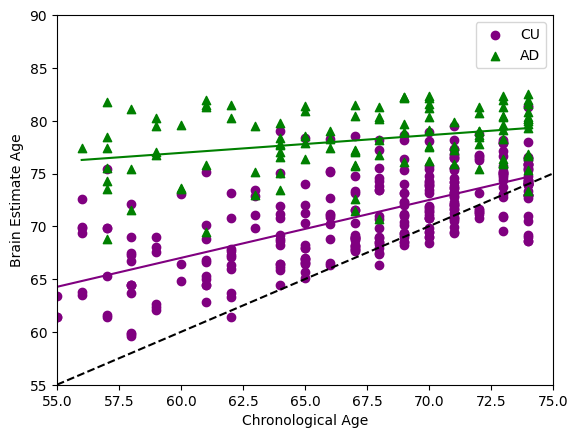

Slope for CU Model A female: 0.5481425998625856 x+ 34.121727693717645
Slope for AD Model A female: 0.1676982212501907 x+ 66.89353430403105
The IDV for Model A female is: 8.042922000507733
MAE for CU Model A female line of best fit: 2.569787046322846 3.1747859364858626
MAE for AD Model A female line of best fit: 2.2920017418657435 2.8617718258980793
Standard deviation for CU Model A female line of best fit: 3.1747859364858626
Standard deviation for AD Model A female line of best fit: 2.8617718258980793
IDV: 0.7894187215824029
IDVP: 0.9503872629192825
IDVP: 0.900709041853729
IDVP: 0.8175919640397611
IDVP: 0.6915935808335603
IDVP: 0.518593837678437


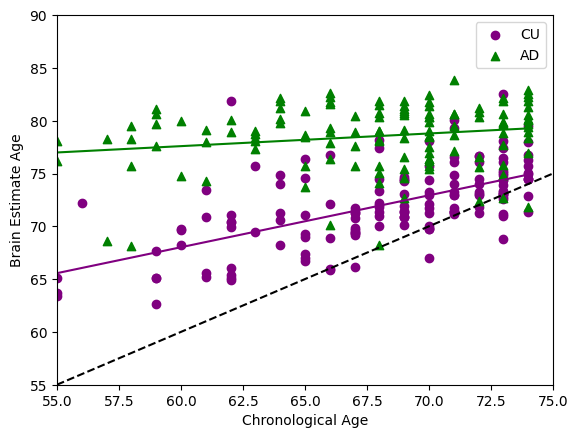

Slope for CU Model B male: 0.49139278255584895 x+ 38.53588811183216
Slope for AD Model B male: 0.11989298093302339 x+ 70.39942738191188
The IDV for Model B male is: 7.716052164596059
MAE for CU Model B male line of best fit: 2.2166199251297924 2.93186512865201
MAE for AD Model B male line of best fit: 2.3040527827834265 2.9923482592414943
Standard deviation for CU Model B male line of best fit: 2.93186512865201
Standard deviation for AD Model B male line of best fit: 2.9923482592414943
IDV: 0.7788369965823732
IDVP: 0.9463404004213155
IDVP: 0.8939134745142155
IDVP: 0.8072545554039688
IDVP: 0.6773218526412873
IDVP: 0.5006102314646307


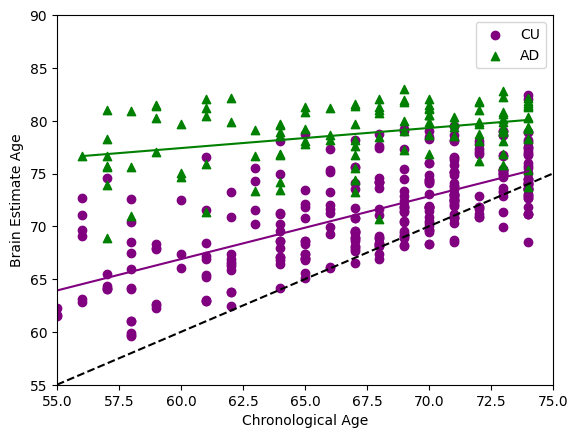

Slope for CU Model C female: 0.5944949634320407 x+ 31.22530084939748
Slope for AD Model C female: 0.19051379021667664 x+ 65.97853499932869
The IDV for Model C female is: 8.494457890932544
MAE for CU Model C female line of best fit: 2.676867786456848 3.2816797145052985
MAE for AD Model C female line of best fit: 2.0863668135701507 2.682551347000114
Standard deviation for CU Model C female line of best fit: 3.2816797145052985
Standard deviation for AD Model C female line of best fit: 2.682551347000114
IDV: 0.8161779165577027
IDVP: 0.9646193038248726
IDVP: 0.9225644452941095
IDVP: 0.8466416220668354
IDVP: 0.7243703858093905
IDVP: 0.5488930516508863


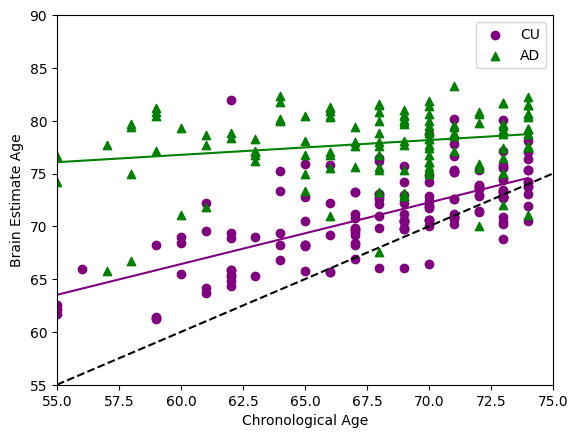

Slope for CU Model C male: 0.5824519511387439 x+ 31.477892642704788
Slope for AD Model C male: 0.13970232813255998 x+ 68.38747429820972
The IDV for Model C male is: 8.13085616010298
MAE for CU Model C male line of best fit: 2.1971437427078833 2.8968995899352605
MAE for AD Model C male line of best fit: 2.3876953936570326 3.1579937070896635
Standard deviation for CU Model C male line of best fit: 2.8968995899352605
Standard deviation for AD Model C male line of best fit: 3.1579937070896635
IDV: 0.7834734187841655
IDVP: 0.9619700177521285
IDVP: 0.9125516826765241
IDVP: 0.8209057532621046
IDVP: 0.6720217450041971
IDVP: 0.4602200773656894


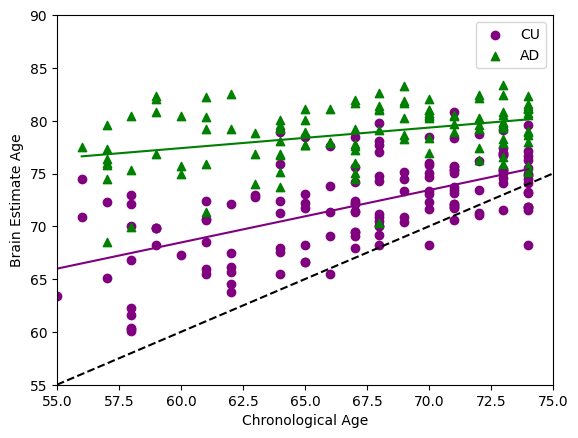

Slope for CU Model D female: 0.4956142831848549 x+ 38.73081469067533
Slope for AD Model D female: 0.19449540579472935 x+ 65.73393328174328
The IDV for Model D female is: 7.430391560709785
MAE for CU Model D female line of best fit: 2.746433968360714 3.3844203334041985
MAE for AD Model D female line of best fit: 2.0442150683546534 2.640128411909862
Standard deviation for CU Model D female line of best fit: 3.3844203334041985
Standard deviation for AD Model D female line of best fit: 2.640128411909862
IDV: 0.7664259142735128
IDVP: 0.9177133699623564
IDVP: 0.8633529464961286
IDVP: 0.7848431956423623
IDVP: 0.6783789439786532
IDVP: 0.5429721706985704


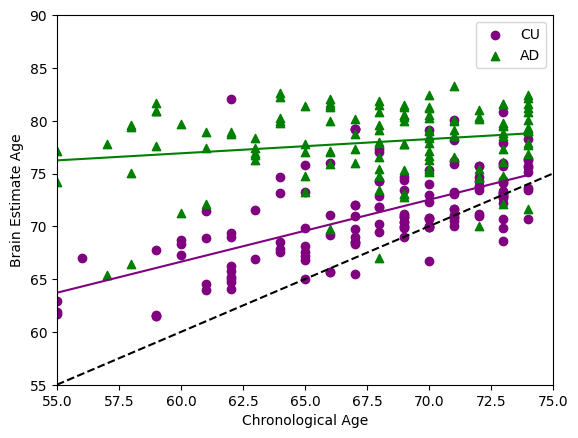

Slope for CU Model D male: 0.5869095621904685 x+ 31.429125637943315
Slope for AD Model D male: 0.13447582660898036 x+ 68.84758111180474
The IDV for Model D male is: 8.010262661064695
MAE for CU Model D male line of best fit: 2.4847363305803287 3.227595295282288
MAE for AD Model D male line of best fit: 2.544545966190674 3.32302479598047
Standard deviation for CU Model D male line of best fit: 3.227595295282288
Standard deviation for AD Model D male line of best fit: 3.32302479598047
IDV: 0.7432156262973469
IDVP: 0.9443227931710332
IDVP: 0.8831723792412635
IDVP: 0.7786370152044375
IDVP: 0.6198442933443039
IDVP: 0.4055172624373284


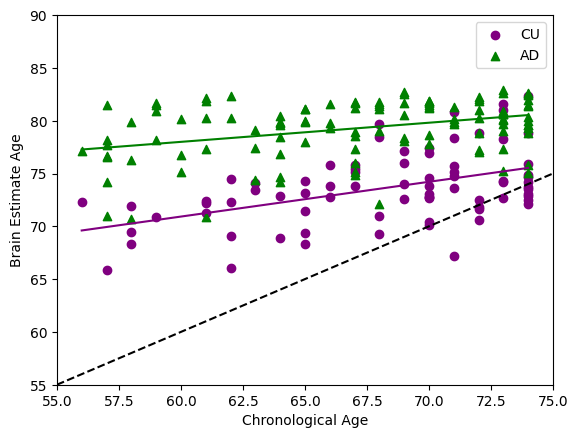

Slope for CU Model E female: 0.3291745026684399 x+ 51.17276934239527
Slope for AD Model E female: 0.18123240287950917 x+ 67.12415162695224
The IDV for Model E female is: 6.335145798276476
MAE for CU Model E female line of best fit: 2.4082081088900193 2.9687809363113407
MAE for AD Model E female line of best fit: 1.9899503684647077 2.534490090272196
Standard deviation for CU Model E female line of best fit: 2.9687809363113407
Standard deviation for AD Model E female line of best fit: 2.534490090272196
IDV: 0.7458248728363148
IDVP: 0.8450247971064262
IDVP: 0.8022508135325414
IDVP: 0.75144173051567
IDVP: 0.6921759691619808
IDVP: 0.6242995118858039


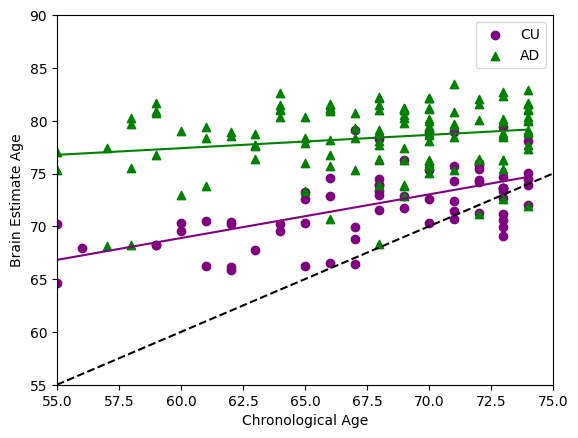

Slope for CU Model E male: 0.41348183597030846 x+ 44.08009866006608
Slope for AD Model E male: 0.12590087942480496 x+ 69.84557470711265
The IDV for Model E male is: 7.0727138715888405
MAE for CU Model E male line of best fit: 2.167616268734075 2.7567753002533633
MAE for AD Model E male line of best fit: 2.421046952015871 3.0910320796168533
Standard deviation for CU Model E male line of best fit: 2.7567753002533633
Standard deviation for AD Model E male line of best fit: 3.0910320796168533
IDV: 0.7557447827445131
IDVP: 0.9112820958856224
IDVP: 0.8547383327824563
IDVP: 0.7740330674828362
IDVP: 0.6655895040693044
IDVP: 0.5284474394299695


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.integrate import quad

def line_of_best_fit(x, slope, intercept):
    return slope * x + intercept

def calculate_mae(y_true, y_pred, slope, intercept):
    best_fit_vals = line_of_best_fit(y_true, slope, intercept)
    return mean_absolute_error(y_pred, best_fit_vals)

def integrand(x, a, b, c, d):
    return (c * x + d) - (a * x + b)

def plot_scatter_with_fit(y_true_cn, y_pred_cn, y_true_ad, y_pred_ad, x_label, y_label, group_label):
    fig, ax = plt.subplots()
    ax.scatter(y_true_cn, y_pred_cn, marker='o', label='CU',color='purple')
    ax.scatter(y_true_ad, y_pred_ad, marker='^', label='AD',color='green')
    ax.legend()
    ax.plot([55, top_age], [55, top_age], linestyle='--', color='black')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(55, top_age)
    ax.set_ylim(55, 90)

    unique_y_true_cn = np.unique(y_true_cn)
    unique_y_true_ad = np.unique(y_true_ad)
    ax.plot(unique_y_true_cn, np.poly1d(np.polyfit(y_true_cn, y_pred_cn, 1))(unique_y_true_cn), color='purple', label='Line of Best Fit (CU)')
    ax.plot(unique_y_true_ad, np.poly1d(np.polyfit(y_true_ad, y_pred_ad, 1))(unique_y_true_ad), color='green', label='Line of Best Fit (AD)')
    plt.show()

    

def process_data(y_true_cn, y_pred_cn, y_true_ad, y_pred_ad, group_label):
    plot_scatter_with_fit(y_true_cn, y_pred_cn, y_true_ad, y_pred_ad, 'Chronological Age', 'Brain Estimate Age', group_label)
    
    coefficients_cn = np.polyfit(y_true_cn, y_pred_cn, 1)
    slope_cn, y_int_cn = coefficients_cn
    coefficients_ad = np.polyfit(y_true_ad, y_pred_ad, 1)
    slope_ad, y_int_ad = coefficients_ad

    print(f"Slope for CU {group_label}:", (slope_cn),"x+",y_int_cn)
    print(f"Slope for AD {group_label}:", (slope_ad),"x+",y_int_ad)

    diff_factor, _ = quad(integrand, 55, top_age, args=(slope_cn, y_int_cn, slope_ad, y_int_ad))
    print(f"The BAD for {group_label} is:", diff_factor/20)


    


    def calculate_std(y_true, y_pred, slope, intercept):
        # Calculate residuals
        residuals = y_pred - (slope * y_true + intercept)
        # Calculate standard deviation of residuals
        std_dev = np.std(residuals)
        return std_dev
    mae_cn = calculate_mae(y_true_cn, y_pred_cn, slope_cn, y_int_cn)
    mae_ad = calculate_mae(y_true_ad, y_pred_ad, slope_ad, y_int_ad)

    cn_sigma = calculate_std(y_true_cn, y_pred_cn, slope_cn, y_int_cn)
    ad_sigma = calculate_std(y_true_ad, y_pred_ad, slope_ad, y_int_ad)

    print(f"MAE for CU {group_label} line of best fit:", mae_cn)
    print(f"MAE for AD {group_label} line of best fit:", mae_ad)
    
    print(f"Standard deviation for CU {group_label} line of best fit:", cn_sigma)
    print(f"Standard deviation for AD {group_label} line of best fit:", ad_sigma)


    # Define the fumltion for mu
    def mu_fumltion_cn(slope,t,cn_int):#this find the "average", or point on the LOBF
        return slope * t + cn_int
    def mu_fumltion_ad(slope,t,ad_int):#this find the "average", or point on the LOBF
        return slope * t + ad_int
        

        # Define the normal PDFs where mu is a fumltion of t
    def normal_pdf_cn(x, t, sigma,slope,int):
            mu = mu_fumltion_cn(slope,t,int)
            return norm.pdf(x, mu, sigma)

    def normal_pdf_ad(x, t, sigma,slope,int):
        mu = mu_fumltion_ad(slope,t,int)
        return norm.pdf(x, mu, sigma)

    def diff_at_point(x, t, cn_slope, ad_slope, cn_int, ad_int, cn_sigma, ad_sigma):
        pdf_differemle = abs(normal_pdf_cn(x, t, cn_sigma, cn_slope, cn_int) - normal_pdf_ad(x, t, ad_sigma, ad_slope, ad_int))
        return pdf_differemle
    def integrate_diff_over_t(t):
        a,b= quad(diff_at_point, -np.inf, np.inf, args=(t, slope_cn, slope_ad, y_int_cn, y_int_ad, cn_sigma, ad_sigma))
        return a
    t_min = 55
    t_max = top_age
    
    integrated_differemle, error = quad(integrate_diff_over_t, t_min, t_max)
    integrated_difference1, error = quad(integrate_diff_over_t, 55, 59)

    integrated_difference2, error = quad(integrate_diff_over_t, 59, 63)
    integrated_difference3, error = quad(integrate_diff_over_t, 63, 67)
    integrated_difference4, error = quad(integrate_diff_over_t, 67, 71)
    integrated_difference5, error = quad(integrate_diff_over_t, 71,75)
    integrated_difference, error = quad(integrate_diff_over_t, 55, top_age)
    
    print("ID Valye:",(integrated_differemle)/40)
##################### Uncommment below sections for ID value of limited ranges. ##################
    '''
    print("IDV1:",integrated_difference1/8)
    print("IDV2:",integrated_difference2/8)
    print("IDV3:",integrated_difference3/8)
    print("IDV4:",integrated_difference4/8)
    print("IDV5:",integrated_difference5/8)
'''

# Assuming y_test1, ensemble_prediction_cn1, y_female_ad, ensemble_prediction_ad1, y_test2, ensemble_prediction_cn2, y_non_ad, ensemble_prediction_ad2 are defined
#process_data(y_test2[y_test2<top_age], ave_ensemble_prediction_cn4_non[y_test2<75], y_non_ad, ave_ensemble_prediction_ad4_non, 'ml')

############################################################################################################################################################
process_data(smooth_rl_vals_cu_A[smooth_rl_vals_cu_A<top_age] ,ave_result_cu_A[smooth_rl_vals_cu_A<top_age],                smooth_rl_vals_ad_A ,ave_result_ad_A,  'Model A female')
process_data(smooth_rl_vals_cu_B[smooth_rl_vals_cu_B<top_age] ,ave_result_cu_B[smooth_rl_vals_cu_B<top_age],                smooth_rl_vals_ad_B ,ave_result_ad_B,  'Model B male')

process_data(smooth_rl_vals_cu_C_fm[smooth_rl_vals_cu_C_fm<top_age] ,ave_result_cu_C_fm[smooth_rl_vals_cu_C_fm<top_age],                smooth_rl_vals_ad_C_fm ,ave_result_ad_C_fm,  'Model C female')
process_data(smooth_rl_vals_cu_C_ml[smooth_rl_vals_cu_C_ml<top_age] ,ave_result_cu_C_ml[smooth_rl_vals_cu_C_ml<top_age],                smooth_rl_vals_ad_C_ml ,ave_result_ad_C_ml,  'Model C male')

process_data(smooth_rl_vals_cu_D_fm[smooth_rl_vals_cu_D_fm<top_age] ,ave_result_cu_D_fm[smooth_rl_vals_cu_D_fm<top_age],                smooth_rl_vals_ad_D_fm ,ave_result_ad_D_fm,  'Model D female')
process_data(smooth_rl_vals_cu_D_ml[smooth_rl_vals_cu_D_ml<top_age] ,ave_result_cu_D_ml[smooth_rl_vals_cu_D_ml<top_age],                smooth_rl_vals_ad_D_ml ,ave_result_ad_D_ml,  'Model D male')

process_data(smooth_rl_vals_cu_E_fm[smooth_rl_vals_cu_E_fm<top_age] ,ave_result_cu_E_fm[smooth_rl_vals_cu_E_fm<top_age],                smooth_rl_vals_ad_E_fm ,ave_result_ad_E_fm,  'Model E female')
process_data(smooth_rl_vals_cu_E_ml[smooth_rl_vals_cu_E_ml<top_age] ,ave_result_cu_E_ml[smooth_rl_vals_cu_E_ml<top_age],                smooth_rl_vals_ad_E_ml ,ave_result_ad_E_ml,  'Model E male')
##############################################################################################################################################################


